# One IRKGL16 Integration Hénon-Heiles IVP

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Definition-of-the-problem">Definition of the problem</a></li>
    <li><a href="#Integration">Integration</a></li>
    <li><a href="#Error-in-energy">Error in energy</a></li>
    <li><a href="#Error-in-position">Error in position</a></li>
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots

PATH_IRKGL="../../../../IRKGaussLegendre.jl-master/IRKGaussLegendre.jl-master/"
include(string(PATH_IRKGL,"src/IRKGaussLegendre.jl"))
using .IRKGaussLegendre  ## bertsio lokala exekutatzeko  

##### <a href="#top">Hasierara</a>

## Initial value problem: Hénon-Heiles

We consider the Hénon-Heiles model which is Hamiltonian with

\begin{align*}
H(q,p)=\frac{1}{2} (p_1^2+p_2^2)+\frac{1}{2}(q_1^2+q_2^2)+q_1^2q_2-\frac{1}{3}q_2^3
\end{align*}

and the corresponding system

\begin{align*}
& \frac{dq_1}{dt}=p_1, \quad 
\frac{dq_2}{dt}=p_2, \\
& \frac{dp_1}{dt}=-q_1-2q_1q_2, \quad 
 \frac{dp_2}{dt}=-q_2-q_1^2+q_2^2
\end{align*}

In [2]:
PATH_ODES=string(PATH_IRKGL,"ODEProblems/")
include(string(PATH_ODES,"HenonHeiles.jl"));

In [3]:
# Gemetric Numerical Integration 15.page

q0=[0,3/10]
p0=[0, 2/10]

# Non-Chaotic solution H0=1/12

H0=1/12
U0=Potential_U(q0[1],q0[2])
p0[1]=sqrt(2*H0-2*U0-p0[2]^2)
p = []

u0=vcat(q0,p0)
u0_B=BigFloat.(u0)
H0_1=HenonHeliesHam(u0_B)

println("Problem1: non-chaotic solution, H0=",Float32(H0_1))

t0 = 0.
tF = 2*pi*1e6
tspan=(t0,tF)

prob_1 = ODEProblem(HenonHeilesODE!, u0, tspan)
probDyn_1=DynamicalODEProblem(HenonHeilesODEq!,HenonHeilesODEv!,q0,p0,tspan)
prob2nd_1=SecondOrderODEProblem(HenonHeilesODE2nd!,p0,q0,(t0,tF));


Problem1: non-chaotic solution, H0=0.083333336


##### <a href="#top">Back to the top</a>

## Integration

### IRKNGL 

In [4]:
dt0 = 2*pi/24
m0=120000
m0 = max(1,div(Int64(ceil((tF-t0)/dt0)),1000))
saveat=m0*dt0
println("dt = $dt0,  m=$m0, n=$(tF/saveat)")

alg=IRKGL16(simd=true, mstep=m0)
sol=solve(prob_1, alg, dt=dt0, adaptive=false)
sol.retcode

dt = 0.2617993877991494,  m=24000, n=1000.0


ReturnCode.Success = 1

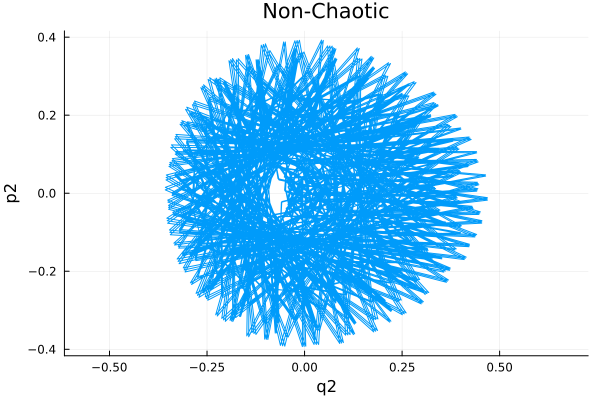

In [5]:
q1= [u[1] for u in sol.u]
q2 = [u[2] for u in sol.u]
p1 = [u[3] for u in sol.u]
p2 = [u[4] for u in sol.u]
pl1=plot(q2,p2, aspect_ratio=1, title="Non-Chaotic", legend=false, xlabel="q2", ylabel="p2")


### IRKNGL (exact solution)

In [6]:
dt1 = dt0/2
m1= 2*m0
saveat=m1*dt1
println("dt = $dt0,  m=$m0, n=$(tF/saveat)")

alg=IRKGL16(simd=true, mstep=m1)
sol1=solve(prob_1, alg, dt=dt1, adaptive=false)
sol1.retcode

dt = 0.2617993877991494,  m=24000, n=1000.0


ReturnCode.Success = 1

In [7]:
[sol1.t[1:10] sol.t[1:10] sol1.t[end-9:end] sol.t[end-9:end]]

10×4 Matrix{Float64}:
     0.0       0.0   6.22664e6  6.22664e6
  6283.19   6283.19  6.23292e6  6.23292e6
 12566.4   12566.4   6.2392e6   6.2392e6
 18849.6   18849.6   6.24549e6  6.24549e6
 25132.7   25132.7   6.25177e6  6.25177e6
 31415.9   31415.9   6.25805e6  6.25805e6
 37699.1   37699.1   6.26434e6  6.26434e6
 43982.3   43982.3   6.27062e6  6.27062e6
 50265.5   50265.5   6.2769e6   6.2769e6
 56548.7   56548.7   6.28319e6  6.28319e6

<a href="#top">Back to the top</a>

## Errors in energy

In [8]:
function ErrorEnergy(H0, Ham, sol, parms_B)

    H = [Ham(BigFloat.(u)) for u in sol.u]
    ΔH0 = @. Float64(abs(H/H0-1))
    H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
   
    return ΔH0, H_lerr

end

ErrorEnergy (generic function with 1 method)

In [9]:
u0_B = BigFloat.(u0)
H0=HenonHeliesHam(u0_B)

ΔH0, H_lerr=ErrorEnergy(H0, HenonHeliesHam, sol, [])
ΔH0_1, H_lerr_1=ErrorEnergy(H0, HenonHeliesHam, sol1, [])
(maximum(ΔH0), maximum(H_lerr), maximum(ΔH0_1), maximum(H_lerr_1))

(1.1282222351771799e-13, 9.240594961369064e-15, 5.647489529763779e-14, 6.408762530640723e-15)

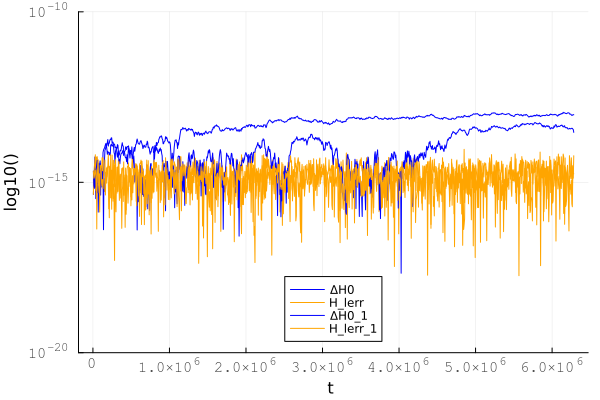

In [10]:
yrange=(1e-20,1e-10)
plot(title="",xlabel="t ", ylabel="log10()", 
     yscale=:log10, ylims=yrange,
     xtickfont = font(8, "Courier"),
     ytickfont = font(8, "Courier"),
     legend=:bottom)
plot!(sol.t,abs.(ΔH0),label="ΔH0", color="blue")
plot!(sol.t[2:end],abs.(H_lerr),label="H_lerr", color="orange")
plot!(sol.t,abs.(ΔH0_1),label="ΔH0_1", color="blue")
plot!(sol.t[2:end],abs.(H_lerr_1),label="H_lerr_1", color="orange")

<a href="#top">Back to the top</a>

## Errors in position

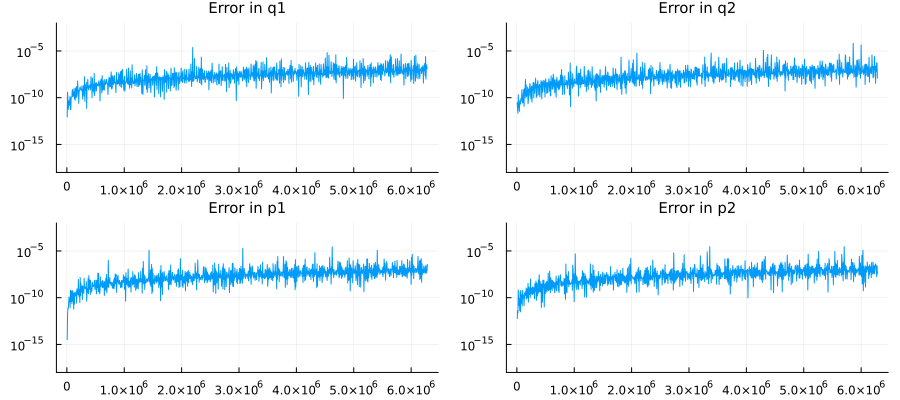

In [11]:
error_q1=map((u,u1)->abs(BigFloat(u[1]/u1[1]-1)), sol.u[2:end], sol1.u[2:end])
error_q2=map((u,u1)->abs(BigFloat(u[2]/u1[2]-1)), sol.u[2:end], sol1.u[2:end])
error_p1=map((u,u1)->abs(BigFloat(u[3]/u1[3]-1)), sol.u[2:end], sol1.u[2:end])
error_p2=map((u,u1)->abs(BigFloat(u[4]/u1[4]-1)), sol.u[2:end], sol1.u[2:end])

yrange=(1e-18,1e-2)
pl1=plot(sol.t[2:end], error_q1, title="Error in q1",  titlefontsize=10,
     yscale=:log10, xlabel="", ylabel="", ylimits=yrange, legend=false)
#
pl2=plot(sol.t[2:end], error_q2, title="Error in q2",  titlefontsize=10,
     yscale=:log10, xlabel="", ylabel="", ylimits=yrange, legend=false)
#
pl3=plot(sol.t[2:end], error_p1, title="Error in p1",  titlefontsize=10,
     yscale=:log10, xlabel="", ylabel="", ylimits=yrange, legend=false)
#
pl4=plot(sol.t[2:end], error_p2, title="Error in p2",  titlefontsize=10,
     yscale=:log10, xlabel="", ylabel="", ylimits=yrange, legend=false)

plot(pl1, pl2, pl3, pl4,
layout=(2,2), size=(900,400),plot_title="")